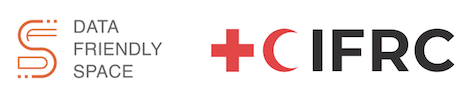
# IFRC Operational Learnings Document Analysis Notebook

## Introduction

This notebook demonstrates a workflow for analyzing humanitarian documents using natural language processing techniques. It combines various tools and approaches to extract valuable insights from text data. The workflow covers tasks such as classification, summarization, similarity analysis, and more.

## Written By

This notebook was written by Nicolò Tamagnone, an NLP/ML Senior Engineer at Data Friendly Space. Data Friendly Space has a dedicated team of experts specializing in data science and AI-driven solutions for social impact. With a strong focus on the humanitarian sector, Data Friendly Space leverages cutting-edge technologies to address critical challenges and promote positive change.

## Notebook Structure

This notebook is organized into several sections that represent distinct steps of the analysis process. Each section is accompanied by code snippets and explanations to guide you through the process. The main sections of the notebook include:

1. **Data Loading and Preprocessing**: This section covers loading the dataset, applying filters, and preparing the data for further analysis.

2. **Classification Model Training**: Here, a text classification model is trained to categorize excerpts from the dataset into predefined classes.

3. **Document Similarity Analysis**: This section focuses on computing the similarity between a query and document excerpts to identify relevant documents.

4. **Summarization and Extraction**: Summarization techniques are used to generate concise summaries of document content, with the ability to filter based on specific criteria.

5. **Text Preprocessing and Linguistic Analysis**: The notebook provides tools for text preprocessing, cleaning, and linguistic analysis to enhance the quality of the text data.

## Guide to Using the Notebook

Follow these steps to effectively use this notebook for humanitarian document analysis:

1. **Data Loading**: Load in te current instance the following files:
*   operational_learnings_data.csv
*   val_df_08082023.csv
*   train_df_08082023.csv
*   test_df_08082023.csv

2. **Unseen File Upload**: Once the Appeal Documents folder has been created please upload an appeal document that is not present on GO dataset. Drag and drop the file into the folder. Unseen documents can be downloaded thought the 'get_emergency_appeals_with_doc' method.
*   10207.pdf

3. **Load Classification Model**: The model points to a shared drive, make sure you redirect it to the foler where the classification model is hosted.

Throughout the notebook, code comments and explanations provide guidance and insights into the underlying processes. Feel free to customize parameters, experiment with different models, and explore various analyses to suit your specific needs.

Let's get started by loading the data and proceeding through each section step by step.

NB. LLM models features are provided, for semplicity, using OpenAI models. In order to use them an OpenAI API key muset be provided. If a you want to use a self-hosted model, code should be reshaped. 

In [3]:
import pandas as pd
import numpy as np
import requests
import time, os, base64, random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import pipeline
from deep_parser import TextFromFile # pip install git+https://github.com/the-deep/deepex@newformat 
# i made some test also on IFRC documents in order to optimize the text extraction for them. 
# I have a couple of ideas, but not pushed for now for costs reasons. 
import openai
os.environ["OPENAI_API_KEY"] = "token-here"
openai.api_key = "token-here"

In [ ]:
# GO Operational Learnings data. Probably also this one can be downlaoded through an api endpoint.

go_url = "./dataset/operational_learnings_data.csv"
go_df = pd.read_csv(go_url) 

In [ ]:
from polyfuzz import PolyFuzz
from polyfuzz.models import EditDistance
from jellyfish import jaro_winkler_similarity

random.seed(42)
jellyfish_matcher = EditDistance(n_jobs=1, scorer=jaro_winkler_similarity)


def get_appeal_documents(task: str = "appeal_document"):
    
    """
    getting all appeals documents
    """
    i=0
    total = []
    while True:
        call = requests.get("https://goadmin.ifrc.org/api/v2/{}/?offset={}".format(task, i))
        results = call.json()
        time.sleep(1)
        if len(results["results"])>0:
            total.extend(results["results"])
            print(f"extended: {i}")
            i+=50
        else:
            break
            
    return pd.DataFrame(total)


def download_appeal_documents(appeals_dataset, output_dir, ids_column: str = "id"):
    
    """
    download appeals documents and save them in {output_dir}
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    for x in appeals_dataset.iterrows():
        _, data = x
        name = f"{data[ids_column]}.pdf"

        if name in os.listdir(output_dir):
            print(f"{name} already in db")
            continue
        try:
            url = data.document_url
            if not url: 
                url = data.document
                if not url:
                    print(f"no document info, id: {data[ids_column]}")
                    continue
            req = requests.get(url)
            if req.status_code==200:
                with open(f"{output_dir}/{name}", "wb") as f:
                    f.write(req.content)
            else:
                print(f"Some error occurs in {data[ids_column]}")
        except Exception as e:
            print(f"Some error occurs in {data[ids_column]}. error: {e}")
            

def get_negative_samples(group, docs_dir: str, min_length: int = 20, min_sim: float = 0.45):
    
    """
    Method for creation of lessons learned and challenges tagged data.
    There is a stategy about mapping the GO excerpts in the corresponding excerpts in raw PDFs through 
    a string levenshtein similiraty.
    Then for each excerpt some negatives excerpts (Other) are - for now - randomly added.
    Also the positives are extended with the corrisponding raw text extracted from the document using
    a custom parsing library (TextFromFile)
    """
    negatives, positives = [], []
    n = len(group)
    ids = list(set(group[group.id.notna()].id))
    if not ids: return positives, negatives
    
    for _id in ids:
        try:
            with open(os.path.join(docs_dir, f"{int(_id)}.pdf"), "rb") as f:
                document = base64.b64encode(f.read())
                base = TextFromFile(document)
                text, _  = base.extract_text(output_format="list")
            
                
            text = [line for page in text for line in page if len(line.split())>=min_length]
            if not text: return positives, negatives
            
            model = PolyFuzz(jellyfish_matcher).match(group.Excerpt.tolist(), text)
            matches = model.get_matches()
            to_matches = matches.To.tolist()
            positives_match = matches[(matches.Similarity>min_sim) & (matches.Similarity<1)]
            positives_match = pd.merge(group[["Excerpt", "Finding"]], 
                         positives_match[["From", "To"]], 
                         right_on="From", 
                         left_on="Excerpt", 
                         how="inner").drop_duplicates("Excerpt")[["Excerpt", "Finding"]]
            positives.extend([(a, b) for a, b in zip(positives_match.Excerpt, positives_match.Finding)])

            j = 0
            while len(negatives)<n*2 and j<=n*3:
                
                random_sampled = random.choice(text)
                if random_sampled not in to_matches:
                    negatives.append(random_sampled)
                    to_matches.append(random_sampled)
                j+=1
                
            
        except Exception as e:
            print(e)
            return positives, negatives
    return positives, negatives


def create_dataset(go_dataset, appeals, appeals_dir: str):
    
    fdocs = appeals[appeals.apply(lambda x: True if "final report" in x["name"].lower() else False, axis=1)]
    fdocs.reset_index(inplace=True, drop=True)
    
    merge = pd.merge(go_dataset, fdocs, 
                     left_on="Operation", 
                     right_on="appeal", 
                     how="left")
    
    return merge
    
    merge_groups = [d for _, d in merge.groupby("Operation")]
    posnegs = [get_negative_samples(g, appeals_dir) for g in merge_groups]
    positives = [a for c,_ in posnegs for a in c]
    negs = [a for _, c in posnegs for a in c]
    
    final = pd.concat([
        merge[["Excerpt", "Finding"]], 
        pd.DataFrame([(a, "Other") for a in negs], columns=["Excerpt", "Finding"])
    ]).sample(frac=1)
    
    final1 = pd.concat([final, pd.DataFrame(positives, columns=["Excerpt", "Finding"])])
    return final1


def get_emergency_appeals_with_doc(save: bool = False, output_dir: str = None):
    
    """
    method for getting the emergency appeal documents
    """
    appeal = get_appeal_documents(task="appeal")
    appeal_doc = get_appeal_documents()
    appeal["aid"] = appeal["aid"].apply(int)
    merge = pd.merge(appeal, 
                     appeal_doc, 
                     left_on="code", 
                     right_on="appeal", 
                     how="right")
    emergency = merge[merge.atype==1]
    
    if save and output_dir:
        download_appeal_documents(emergency, output_dir, ids_column="id_y")
        
    return emergency


def reshape_output(x):
    return x[0][0].get("label")
    
    d = {}
    for el in x:
        d.update({
            el.get("label"): el.get("score")
        })
    return d

In [ ]:
# Call API and download example

docs = get_appeal_documents()

# only Final Report type documents
fdocs = docs[
    docs.apply(lambda x: True if "final report" in x["name"].lower() else False, axis=1)
].reset_index(drop=True)


# download final report docs in a specific directory
download_appeal_documents(fdocs, "./dataset/appeal_documents")

In [ ]:
# Dataset creatn for subsequent classification training

#data = create_dataset(go_df, docs, "./dataset/appeal_documents")

## Training multiclass

an already trained model is provided. Skip this section if you don't want to retrain the classifier

In [ ]:
import torch
import numpy as np
import pandas as pd
import transformers
from tqdm import tqdm, trange
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [ ]:
class PlainDataset(Dataset):
    def __init__(
      self,
      dataframe: pd.DataFrame,
      tokenizer,
      max_length: int = 256,
  ):

        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

        self.text = self.data["Excerpt"]
        self.target = self.data["Finding"]
        self.mlb = LabelBinarizer()
        self.mlb.fit(self.target.to_list())

    def encode_example(self, x, y):

        inputs = self.tokenizer.encode_plus(
            text=x,
            truncation=True,
            add_special_tokens=True,
            padding="max_length",
            max_length=self.max_length,
            return_token_type_ids=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        encoded = {
              "ids": torch.tensor(ids, dtype=torch.long),
              "mask": torch.tensor(mask, dtype=torch.long),
          }

        return (encoded["ids"],
                encoded["mask"],
                self.mlb.transform([y]))
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        excerpt_text = self.text[index]
        tag = self.target[index]
        return self.encode_example(excerpt_text, tag)

In [ ]:
# defining some (hyper) parameters
BATCH_SIZE=32
EPOCHS = 10
DROP_OUT = 0.2
LEARNING_RATE = lr=2e-5
NUM_LABELS = 3
SAMPLE_DATASET = .1

train, val = train_test_split(data, test_size=0.4, stratify=data[["Finding"]])
val, test = train_test_split(val, test_size=0.5, stratify=val[["Finding"]])

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# we call HumBERT model
tokenizer = AutoTokenizer.from_pretrained("nlp-thedeep/humbert")
model = transformers.AutoModelForSequenceClassification.from_pretrained("nlp-thedeep/humbert", num_labels=NUM_LABELS)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = transformers.AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
    correct_bias=True
)

df_train_dataset = PlainDataset(dataframe=train, tokenizer=tokenizer, max_length=256)
df_val_dataset = PlainDataset(dataframe=val, tokenizer=tokenizer, max_length=256)
df_test_dataset = PlainDataset(dataframe=test, tokenizer=tokenizer, max_length=256)

train_dataloader = DataLoader(df_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(df_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(df_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    
):

    train_loss_set = []
    for _ in trange(EPOCHS, desc="Epoch"):

        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels  = batch
            optimizer.zero_grad()

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            #print(logits)
            loss = CrossEntropyLoss()(
                logits.view(-1,NUM_LABELS),
                b_labels.type_as(logits).view(-1,NUM_LABELS)
            )

            train_loss_set.append(loss.item())
            loss.backward()
            optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        print("loss: {}".format(tr_loss/nb_tr_steps))

        model.eval()
        logit_preds,true_labels,pred_labels = [],[],[]

        for i, batch in enumerate(val_dataloader):

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():

                outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                b_logit_pred = outs[0]
                _, pred_label = torch.max(b_logit_pred, 1)
                _, true_label = torch.max(b_labels.reshape(-1, NUM_LABELS), 1)
                pred_label = pred_label.to('cpu').numpy()
                true_label = true_label.to('cpu').numpy()
                true_labels.extend(true_label)
                pred_labels.extend(pred_label)

        val_f1 = f1_score(true_labels,pred_labels,average='macro')
        print('Macro-Average F1-score: ', val_f1)

In [ ]:
# example

#train(
#    model,
#    train_dataloader,
#    val_dataloader,
#    optimizer
#)

In [ ]:
# test

def test(
    model,
    test_dataloader,
):
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    for i, batch in enumerate(test_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

                outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

                b_logit_pred = outs[0]
                _, pred_label = torch.max(b_logit_pred, 1)
                _, true_label = torch.max(b_labels.reshape(-1, NUM_LABELS), 1)
                pred_label = pred_label.to('cpu').numpy()
                true_label = true_label.to('cpu').numpy()
                true_labels.extend(true_label)
                pred_labels.extend(pred_label)


    report = classification_report(true_labels,
                                   pred_labels,
                                   zero_division=False,
                                   output_dict=False)
    print(report)
    
"""
Some optimization and other experiments can be done here.
Our first result:

            precision    recall  f1-score   support

           0       0.90      0.82      0.86      1034
           1       0.75      0.96      0.84       958
           2       0.98      0.91      0.94      2518

    accuracy                           0.90      4510
   macro avg       0.88      0.90      0.88      4510
weighted avg       0.91      0.90      0.90      4510



IMO:

Documents are full of false negatives, and the classes are blurry concepts, at least for an NLP algorithm,
that not reflect, or not always reflect, specific semantic properties. Only a classification is not enough
for a detection of this kind of information. In addition, the starting annotated dataset is small/mid sized.
The same discussion can be done in a retrieval context based on query and embeddings similarities.
My idea is to mix the two approach in order to improve a RAG (Retrieve Augmentation Generation)
"""

In [ ]:
#train = pd.read_csv("./dataset/train_df_08082023.csv")
#val = pd.read_csv("./dataset/val_df_08082023.csv")
#test = pd.read_csv("./dataset/test_df_08082023.csv")

# RAG

In [ ]:
"""
Using Generative Models on documents is called RAG. The idea is to use the zero/few shot capabilites 
of these kind of models using data that is not present in their parametric knowledge. The main idea is to
extend a query with context informations retrieved from the document(s) itself. The accuracy of the results is
hightly dependent on retrieving the right context. The standard approach is to use embeddings similarity between
query and sentences in order to find the right ones. But too simple for this case. 
"""

In [ ]:
def get_text(document_path, min_length: int = 20):
    """
    get text of a document. A common a approach is to split the document in chunks of same size,
    (sometimes with some overlaps). Using our library we can split the document in respect of the 
    paragraphs and graphical disposal of the text. IMO is a better appoach. 
    
    """
    with open(document_path, "rb") as f:
        doc = base64.b64encode(f.read())

    r = TextFromFile(doc)
    text = r.extract_text(output_format="list")[0]
    
    return [line for page in text for line in page if len(line.split())>=min_length]

In [ ]:
"""
We then need an embedding model is order to encode our query and document text. 
A lot of application use directly the OpenAI one. 

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
   
   
I searched for a better and open-source approach. 
Following the recent results of the embeddings leaderboard: https://huggingface.co/spaces/mteb/leaderboard,
i decided to use INSTRUCTOR, an instruction-trained embedding model: https://github.com/HKUNLP/instructor-embedding

"""

from InstructorEmbedding import INSTRUCTOR

emb_model = INSTRUCTOR('hkunlp/instructor-base') #also a large and xl version is available

# let's lad also out trained classifier

clf = pipeline("text-classification", model="./models/model2-20230818/", top_k=3)

In [ ]:
def get_query_doc_similarity_scores(
    query,
    embedding_model,
    text,
):
    # for example, for lessons learnt related text. Query: what are the lessons learned?
    query  = [['Represent the question for retrieving supporting documents: ', query]]
    
    # a pre-sentence text can be formulated here
    corpus = [['Represent the humanitarian document for retrieval: ', x] for x in text]
    
    query_embeddings = embedding_model.encode(query)
    corpus_embeddings = embedding_model.encode(corpus)

    sim = cosine_similarity(query_embeddings,corpus_embeddings).tolist()[0]
    idsim = sorted([(i, s) for i, s in enumerate(sim)], key=lambda x: x[1], reverse=True)
    
    return idsim


def classification_scores(model, documents):
    
    """
    getting classification score results for each sentence/paragraph of a document.
    """
    res = []
    placeholder = [
        {'label': 'Other', 'score': 0},
        {'label': 'Challenges', 'score': 0},
        {'label': 'Lessons Learnt', 'score': 0}]
    
    for c in text:
        try:
            cl = clf(c, **tokenizer_kwargs)
            res.append((c, cl[0]))
        except Exception as e:
            res.append((c, placeholder))
    return res


def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def get_results_with_text(similarities, documents, clf_model, tag: str):
    
    """
    IDEA: combining here the classification scores and the embeddings similarity scores in respect 
    of a specific tag (i.e "Lessons Learnt" or "Challenges"), consistent with the search (and so the query)
    that we want to perform.
    
    """
    
    tokenizer_kwargs = {
        'padding': 'max_length',
        'truncation':True,
        'max_length': 256, 
        'add_special_tokens': True, 
        'return_token_type_ids':True
    }
    
    res = []
    for i, c in similarities:
        classification = clf_model(documents[i], **tokenizer_kwargs)
        classification_score = sum([a.get("score") 
                                for a in classification[0] if a.get("label")==tag])
        
        # summing here the classification tag probabilities and the score of similarity.
        #  a research can be done here, in order to have a smarter combination.
        res.append((documents[i], c, classification_score, c+classification_score, classification))
        
    res = [(a, b, c) for a, b, c in zip([c[0] for c in res], 
                                        normalizeData([c[3] for c in res]), 
                                        [c[4] for c in res])]
    res = sorted(res, key=lambda x: x[1], reverse=True)
    
    return res

In [ ]:
# Let's make an example. Let's get a never seen document (an appeal document that is not present on GO dataset)!

text = get_text("./dataset/appeal_documents/10066.pdf")

In [ ]:
embeddings_similarities = get_query_doc_similarity_scores(
    query="what are the lesson learned",
    embedding_model=emb_model,
    text=text
)

In [ ]:
# sorted results for lesson learnt extraction

results = get_results_with_text(
    similarities=embeddings_similarities,
    documents=text,
    clf_model=clf,
    tag="Lessons Learnt"
)

In [ ]:
"""
the retrieve seems to work fine, especially if we consider the complexity of the information. 
The scores are normalized in respect of all sentences/paragraph between 0 and 1. 
I would propose a 0.75 threshold (scores are calculated for all the excerpts). I will add a test here, using the test set.
"""

In [ ]:
# let's go now on using some generative AI and apply our custom retrieve! 

from langchain import PromptTemplate
from langchain.schema import Document
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA


llm = ChatOpenAI(
    temperature=0,
    model="gpt-4"
)

In [ ]:
context = [Document(page_content=c[0]) for c in results if round(c[1], 2)>=0.75]

In [ ]:
context

In [ ]:
embeddings = OpenAIEmbeddings() # this one can be changed with a custom one. 
# here we use the openAI ones just for a quick test. 
vectordb = Chroma.from_documents(documents=context, 
                                 embedding=embeddings)

retriever = vectordb.as_retriever(k=len(context))
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    retriever=retriever)

In [ ]:
tag = "challenges"

query = f"""Imagine to be an humanitarian analyst and wants to find some crucial information across the document.
I'm interest in {tag} informations. 
Please create 10 bullet points based on the documents provided.
Add a final comment about the {tag}.
"""

llm_response = qa(query)
print(llm_response["result"])

# Filtering and Summarization

In [2]:
# As a first example let's run some filtering and summarization on the actual Operational Learning dataset
# provided in the GO platform.

# !pip install tiktoken 
# !pip install gensim
# !pip install wordcloud
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension


import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
go_url = "./dataset/operational_learnings_data.csv"
go_df = pd.read_csv(go_url) 

go_df.head()

,Excerpt,Finding,Sector,Operation,Hazard,Country,Date,Region,PER - Area,PER - Component,Type of operation
0,Considering the short duration of DREF operati...,Lessons Learnt,Disaster Risk Reduction and Climate Action,MDRBF014,Food Insecurity,Burkina Faso,8/19/2017,Africa,Operational Capacity,Activation of Regional and International Support,DREF
1,Lack of experience in the preparation of the D...,Challenges,Disaster Risk Reduction and Climate Action,MDRFJ004,Cyclone,Fiji,4/14/2020,Asia Pacific,Operational Capacity,Activation of Regional and International Support,DREF
2,"Provision of a DREF training, ensuring it cove...",Lessons Learnt,Disaster Risk Reduction and Climate Action,MDRFJ004,Cyclone,Fiji,4/14/2020,Asia Pacific,Operational Capacity,Activation of Regional and International Support,DREF
3,The early launching of DREF as part of the pre...,Lessons Learnt,Disaster Risk Reduction and Climate Action,MDRPH031,Cyclone,Philippines,1/18/2019,Asia Pacific,Operational Capacity,Activation of Regional and International Support,DREF
4,The late deployment of RDRT team meant that th...,Challenges,Disaster Risk Reduction and Climate Action,MDRVN018,Flood,Viet Nam,8/16/2019,Asia Pacific,Operational Capacity,Activation of Regional and International Support,DREF


In [5]:
import openai, os, tiktoken

# let's extend this to rest of openai model max_length. For now we rescrict the selection
# between gpt-4 and gpt-3.5-turbo models
max_tokens_map = {
    "gpt-4": 8192,
    "gpt-3.5-turb0": 4096
}


def get_completion(prompt, model="gpt-4", temperature=0):
    
    messages = [{"role": "user", "content":prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature
    )
    return response.choices[0].message["content"]


def get_num_tokens(prompt, model="gpt-4"):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(prompt))
    return num_tokens


def create_filters_dict(finding, country, sector, hazard):
    
    filters = {
        "finding": finding
    }
    
    if country!=ALL:
        filters.update(
            {
                "country":country
            }
        )
        
    if sector!=ALL:
        filters.update(
            {
                "sector":sector
            }
        )    
        
    if hazard!=ALL:
        filters.update(
            {
                "hazard":hazard
            }
        )
        
    return filters


def get_summary(df, 
                model, 
                filters, 
                temperature: float = 0, 
                prompt_limit: int = 3000,
                by_operation: bool = False):
    
    def format_summary(summaries, by_op: bool = False):
    
        if not by_op:
            summary = " ".join(summaries)
        else:
            summary = []
            for op, t in summaries:
                summary.append(f"Operation: {op}\n")
                summary.append(t)
                summary.append("-"*100)
            summary = "\n".join(summary)
        
        return summary
    
    starting_prompt = """Your task is to generate a summary of excerpts of text about '{}' information.""".format(filters.get("finding"))
    
    if filters.get("country"):
        starting_prompt = starting_prompt + """\nThe provided excerpts refer to '{}' in {}.""".format(
            filters.get("finding"),
            filters.get("country")
        )
    if filters.get("sector"):
        starting_prompt = starting_prompt + """\nThey cointain information about a specific topic: {}""".format(filters.get("sector"))
    
    if filters.get("hazard"):
        starting_prompt = starting_prompt + """\nIn particular, are focused only on '{}' hazard type.""".format(filters.get("hazard"))
        
    starting_prompt = starting_prompt+"""\n\Excerpts are provided as a list of sentences separated by two newlines delimited by triple backticks. Generete an unique summary."""
    starting_prompt = starting_prompt+"""\n Excerpts: ```{}```"""
    # sort the dataframe by Date
    df["Date"] = pd.to_datetime(df["Date"], errors="ignore")
    df.sort_values("Date", inplace=True)
    
    text = "\n\n".join(df.Excerpt.tolist())
    length = get_num_tokens(text)
    
    # we need to split the prompt in order to not go over the tokens max length. 
    # The strategy is to split the excerpts by operation (selectable also as parameters).
    # If the length is over half of maximun, sentences are gruoped in respect of the operation.
    # because in this way we can maintain some sense and not just splitting randomly.
    if length>=round(max_tokens_map.get(model)/2) or by_operation:
        
        summaries = []
        for op, sub_df in df.groupby("Operation"):
            sub_text = "\n\n".join(sub_df.Excerpt.tolist())
            sub_prompt = starting_prompt.format(sub_text)
            sub_summary = get_completion(sub_prompt, model, temperature)
            if by_operation:
                summaries.append((op, sub_summary))
            else:
                summaries.append(sub_summary)
        
        return format_summary(summaries, by_op=by_operation)
    else:
        total_prompt = starting_prompt.format(text)
        summary = get_completion(total_prompt, model, temperature)
        return summary

In [6]:
import re
import nltk
import gensim
import numpy as np

from toolz import pipe
from functools import lru_cache
from collections import Counter
from wordcloud import WordCloud


nltk.download('punkt')
nltk.download('omw-1.4')
### Compiling regex patterns as they might get used many times over ###

# Hardcoded rules for dealing with punctuation marks and other custom symbols
punctuation_replacement_rules = {
    # old patterns: replacement pattern
    "[\u2022,\u2023,\u25E6,\u2043,\u2219]": ",",  # Convert bullet points to commas
    r"[-/:\\]": " ",  # Convert colon, hyphens and forward and backward slashes to spaces
    r"[^a-zA-Z0-9,.; #(++)]": "",  # Preserve spaces, commas, full stops, semicollons for discerning noun chunks
    r"[\(\)]": ""
}

# Patterns for cleaning punctuation, for clean_punctuation()
compiled_punct_patterns = [re.compile(p) for p in punctuation_replacement_rules.keys()]
punct_replacement = list(punctuation_replacement_rules.values())

# Pattern for fixing a missing space between enumerations, for split_sentences()
compiled_missing_space_pattern = re.compile("([a-z])([A-Z])([a-z])")

compiled_nonalphabet_nonnumeric_pattern = re.compile(r"([^a-zA-Z0-9 #(++)+])")
compiled_padded_punctuation_pattern = re.compile(r"( )([^a-zA-Z0-9 #(++)+])")
remove_symbols = re.compile(r"(?:\(|\))")

### Components of the text preprocessing pipeline ###
@lru_cache()
def WordNetLemmatizer():
    nltk.download("wordnet")
    return nltk.WordNetLemmatizer()


@lru_cache()
def get_stopwords():
    """Returns the set of English stopwords from nltk"""
    nltk.download("stopwords")
    from nltk.corpus import stopwords

    return list(set(stopwords.words("english"))) + ["also"]


def lemmatise(term):
    """Apply the NLTK WN Lemmatizer to the term"""
    lem = WordNetLemmatizer()
    return lem.lemmatize(term)


def clean_punctuation(text):
    """Replaces punctuation according to the predefined patterns"""
    for j, pattern in enumerate(compiled_punct_patterns):
        text = pattern.sub(punct_replacement[j], text)
    return text


def remove_punctuation(text):
    """Remove punctuation marks and replace with spaces (to facilitate lemmatisation)"""
    text = compiled_nonalphabet_nonnumeric_pattern.sub(r" ", text)
    text = remove_symbols.sub(r" ", text)
    return text


def pad_punctuation(text):
    """Pad punctuation marks with spaces (to facilitate lemmatisation)"""
    text = compiled_nonalphabet_nonnumeric_pattern.sub(r" \1 ", text)
    return text


def unpad_punctuation(text):
    """Remove spaces preceding punctuation marks"""
    text = compiled_padded_punctuation_pattern.sub(r"\2", text)
    return text


def detect_sentences(text):
  
    """
    Splits a word written in camel-case into separate sentences. This fixes a case
    when the last word of a sentence in not seperated from the capitalised word of
    the next sentence. This tends to occur with enumerations.

    For example, the string "notLike" will be converted to "not. Like"

    Reference: https://stackoverflow.com/questions/1097901/regular-expression-split-string-by-capital-letter-but-ignore-tla
    """
    text = compiled_missing_space_pattern.sub(r"\1. \2\3", text)
    return text


def lowercase(text):
    """Converts all text to lowercase"""
    return text.lower()


def lemmatize_paragraph(text):
    """
    Lemmatizes each word in a paragraph.
    Note that this function has to be included in a processing pipeline as, on
    its own, it does not deal with punctuation marks or capital letters.
    """
    # Lemmatize each word
    text = " ".join([lemmatise(token) for token in text.split(" ")])
    return text


def remove_stopwords(text):
    """Removes stopwords"""
    stopwords = get_stopwords()
    text = " ".join(filter(lambda token: token not in stopwords, text.split(" ")))
    return text
  
def remove_numbers(text):
    text = " ".join([c for c in text.split() if not c.isdigit()])
    return text


def clean_up(text):
    """Removes extra spaces between words"""
    text = " ".join([c for c in text.split() if len(c)>2]).strip()
    return text


def clean_text(text, keep_punct=False):
    """
    Pipeline for preprocessing online job vacancy and skills-related text.
    NB: If 'keep_punct' is True, then commas, full stops and semicollons are preserved

    Args:
        text (str): Text to be processed via the pipeline
    """
    if keep_punct is False:
        return pipe(
            text,
            detect_sentences,
            lowercase,
            remove_punctuation,
            remove_stopwords,
            remove_numbers,
            lemmatize_paragraph,
            clean_up,
        )
    elif keep_punct is True:
        return pipe(
            text,
            detect_sentences,
            lowercase,
            clean_punctuation,
            pad_punctuation,
            lemmatize_paragraph,
            remove_stopwords,
            unpad_punctuation,
            clean_up,
        )

def create_bigrams(docs, return_model: bool = False):
    bigram_phrases = gensim.models.Phrases(docs, min_count=2, threshold=0.5)
    bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
    if return_model: return bigram_phraser
    docs = [bigram_phraser[doc] for doc in docs]
    return docs


def get_total_scores(corpus_by_labels, idf_dict, total: bool = True):

    total_words_scores = []
    if total:
        most = [c for  a in corpus_by_labels for c in a] #general frequencies insted per label
        most = Counter([c for a in most for c in a])
        terms = sorted([(k, np.log(1+v)*idf_dict.get(k)) 
                    for k, v in most.items()],
                   key=lambda x: x[1], reverse=True)
        total_words_scores.append({k: v for k, v in terms})
    else:
        for label, t in corpus_by_labels:
            m = [c for a in t for c in a]
            most = Counter(m)
            terms = sorted([(k, np.log(1+v)*idf_dict.get(k)) 
                    for k, v in most.items()],
                   key=lambda x: x[1], reverse=True)
            total_words_scores.append((label, {k: v for k, v in terms}))

    return total_words_scores


def get_idf(corpus):
    idf = {}
    for doc in corpus:
        words = list(set(doc))
        for c in words:
            if c not in idf.keys():
                idf.update({c: 0})
            idf[c] = idf[c]+1
    for k, v in idf.items():
        idf[k] = np.log(len(corpus)/v)
    return idf


def process_keywords(te, labels_type = "Sector", total: bool = True):
    

    
    b_model = create_bigrams([nltk.word_tokenize(clean_text(c)) 
                                      for c in te["Excerpt"] if isinstance(c, str)], return_model=True)
    if not total:
        groups_by_labels = [(i, list(set(c["Excerpt"]))) 
                        for i, c in te.explode(labels_type).fillna("MISSING").groupby(labels_type)]
    corpus = None
    if total:
        corpus = [[b_model[nltk.word_tokenize(clean_text(c))]] for c in te["Excerpt"]]
    else:
        corpus = [(i, [b_model[nltk.word_tokenize(clean_text(c))] for c in sublist])
                  for i, sublist in groups_by_labels]
        
    if not corpus: return []
    if total:
        idf = get_idf([a for c in corpus for a in c])
    else:
        idf = get_idf([a for _, c in corpus for a in c])

    total_words_scores = get_total_scores(corpus, idf, total=total)
    return total_words_scores


def get_wordcloud(df, by_label: str = None):
    
    def show_plot(im, plot_title: str = "Total"):
        plt.figure(figsize=(10,6))
        plt.axis("off")
        plt.title(plot_title)
        plt.imshow(wc)
        plt.show()
        
    images = []
    wc = WordCloud(background_color="white", 
                   max_words=100,
                   width=1600, 
                   height=800)
    if not by_label:
        keywords = process_keywords(filtered_df, total=True)
        wc.generate_from_frequencies(keywords[0])
        show_plot(wc)
    else:
        keywords = process_keywords(filtered_df, labels_type=by_label, total=False)
        for label, k in keywords:
            wc.generate_from_frequencies(k)
            show_plot(wc, plot_title=label)

[nltk_data] Downloading package punkt to /Users/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nico/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Output

### Filter the dataset

In [7]:
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique


ALL = "ALL"
output = widgets.Output()
dropdown_country = widgets.Dropdown(options=unique_sorted_values_plus_ALL(go_df.Country), 
                                    description="Country:")
dropdown_sector  = widgets.Dropdown(options=unique_sorted_values_plus_ALL(go_df.Sector),
                                    description="Sector:")
dropdown_hazard  = widgets.Dropdown(options=unique_sorted_values_plus_ALL(go_df.Hazard),
                                    description="Hazard:")
dropdown_type = widgets.Dropdown(options=list(set(go_df.Finding)),
                                 description="Finding:",
                                 value = "Lessons Learnt")


def common_filtering(df, country, sector, hazard, type_):
    
    global filtered_df
    
    output.clear_output()
    common_filter = df.copy()
    common_filter = common_filter[common_filter.Finding==type_]
    if country!=ALL:
        common_filter = common_filter[common_filter.Country==country]
    if sector!=ALL:
        common_filter = common_filter[common_filter.Sector==sector]
    if hazard!=ALL:
        common_filter = common_filter[common_filter.Hazard==hazard] 
        
    filtered_df = common_filter.copy()
    with output:
        display(common_filter)
        
        
def dropdown_country_eventhandler(change):   
    common_filtering(go_df, change.new, dropdown_sector.value, dropdown_hazard.value, dropdown_type.value)

def dropdown_sector_eventhandler(change):
    common_filtering(go_df, dropdown_country.value, change.new, dropdown_hazard.value, dropdown_type.value)
    
def dropdown_hazard_eventhandler(change):
    common_filtering(go_df, dropdown_country.value, dropdown_sector.value, change.new, dropdown_type.value)
    
def dropdown_type_eventhandler(change):
    common_filtering(go_df, dropdown_country.value, dropdown_sector.value, dropdown_hazard.value, change.new)
    
dropdown_country.observe(dropdown_country_eventhandler, names='value')
dropdown_sector.observe(dropdown_sector_eventhandler, names='value')
dropdown_hazard.observe(dropdown_hazard_eventhandler, names='value')
dropdown_type.observe(dropdown_type_eventhandler, names='value')

display(dropdown_country)
display(dropdown_sector)
display(dropdown_hazard)
display(dropdown_type)

display(output)

Dropdown(description='Country:', options=('ALL', 'Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', …

Dropdown(description='Sector:', options=('ALL', 'Disaster Risk Reduction and Climate Action', 'Health', 'Livel…

Dropdown(description='Hazard:', options=('ALL', 'Civil Unrest', 'Cold Wave', 'Cyclone', 'Drought', 'Droughts',…

Dropdown(description='Finding:', index=1, options=('Challenges', 'Lessons Learnt'), value='Lessons Learnt')

Output()

## General summary

In [79]:
summ = get_summary(
    filtered_df,
    "gpt-4",
    create_filters_dict(
        dropdown_type.value,
        dropdown_country.value,
        dropdown_sector.value,
        dropdown_hazard.value
    )
)
print(summ)

The lessons learnt from disaster intervention processes in Argentina highlight the importance of community involvement, training, and preparedness. It is crucial to provide training on protection, gender, and inclusion from the beginning of an emergency. The use of the Community Engagement and Accountability (CEA) approach was key to community involvement and better accountability. The accompaniment of the IFRC was instrumental in expanding the coverage and scope of the operation. It is necessary to have volunteers trained specifically in RFL and ensure that staff and volunteers have completed the Stay Safe training before the operation. The importance of having water treatment powders or plants available when setting up temporary collective centres was also noted. Health promotion could have been supplemented with more and better materials. The need to construct key gender messages to facilitate communication between ARC volunteers and victims was also highlighted. It is recommended t

## Summary by Operation

In [80]:
op_summ = get_summary(
    filtered_df,
    "gpt-4",
    create_filters_dict(
        dropdown_type.value,
        dropdown_country.value,
        dropdown_sector.value,
        dropdown_hazard.value
    ),
    by_operation=True
)
print(op_summ)

Operation: MDRAR014

The lessons learnt in Argentina highlight the importance of addressing transport limitations, constructing key gender messages, and monitoring gender-related attitudes in operational spaces. The process of delivering aid generated tension among beneficiaries, indicating a need for careful community engagement. Informational leaflets on hygiene and safe water practices were deemed essential. There was a need to improve the branch's ownership of the EPoA and the organization of external teams. Recreational materials were important during PSS efforts, especially for children. Training and educational materials on gender issues were necessary for all ARC members. Lastly, there was a need to improve work with the provincial and municipal government.
----------------------------------------------------------------------------------------------------
Operation: MDRAR015

The lessons learnt from Argentina highlight the need for improved health promotion materials and strat

## Keywords Extraction and WordClouds

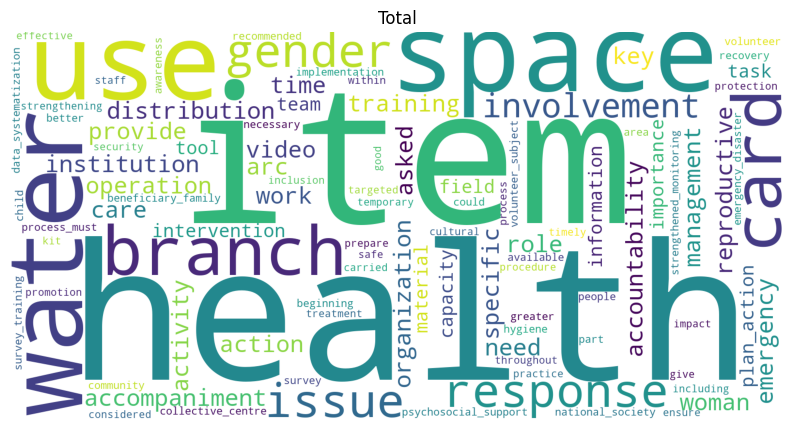

In [81]:
get_wordcloud(
    filtered_df
)

### grouped worldclouds 

In [82]:
# Please select a pivot option. IMO. this kind of wordcloud works better in respect of "Sector" grouped dataset.
selection = widgets.Dropdown(options=["Sector", "Hazard", "Country"])
display(selection)

Dropdown(options=('Sector', 'Hazard', 'Country'), value='Sector')

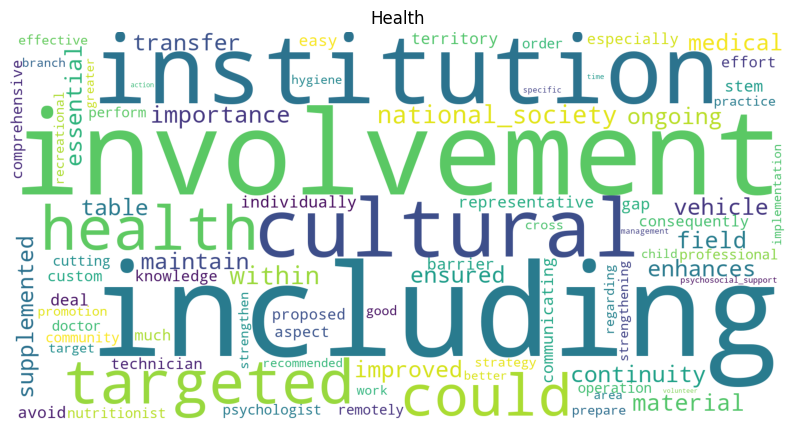

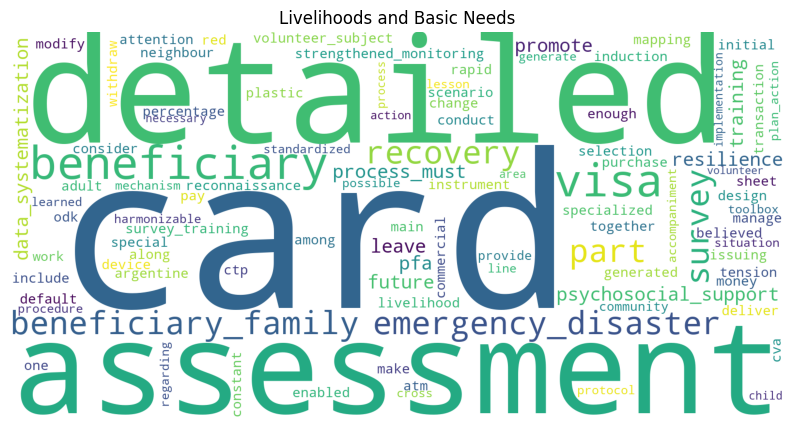

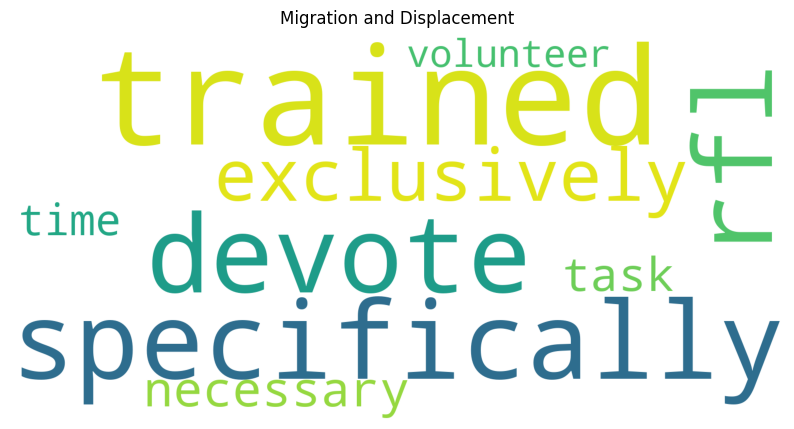

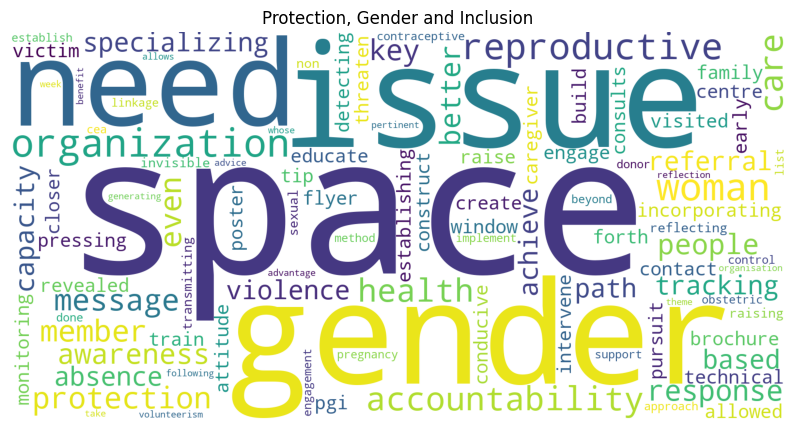

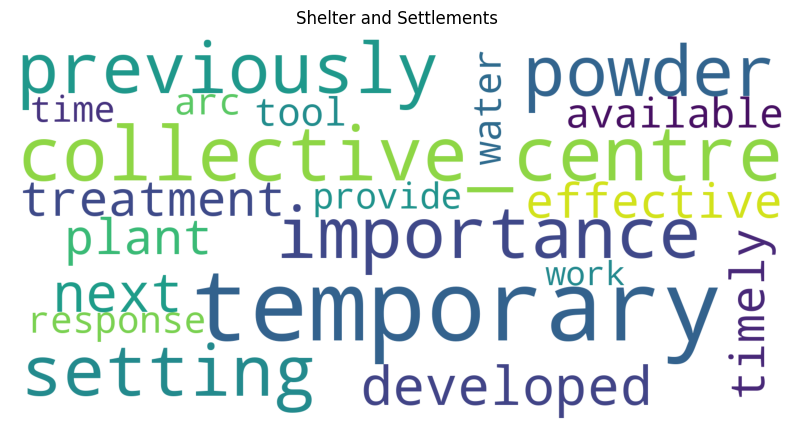

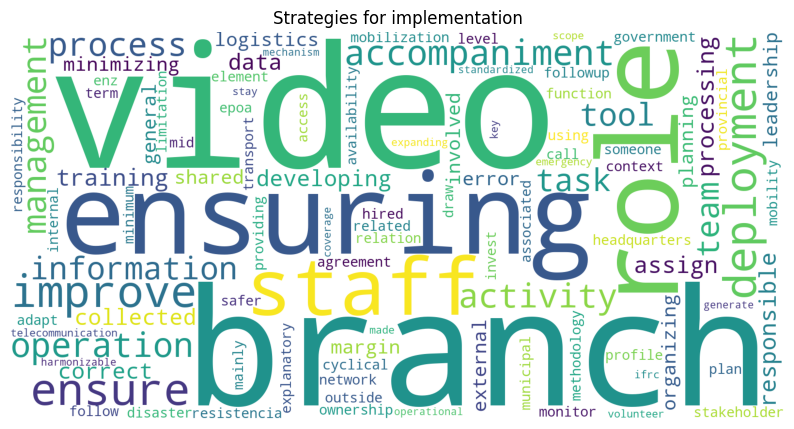

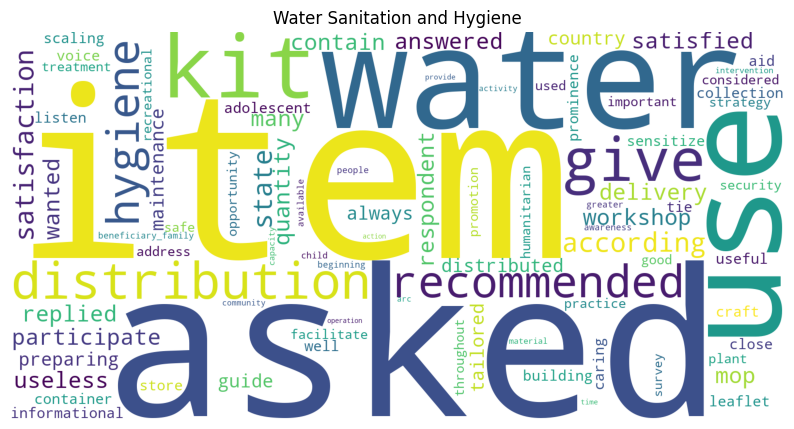

In [83]:
get_wordcloud(
    filtered_df,
    by_label=selection.value
)

### Topics

In [27]:
from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from InstructorEmbedding import INSTRUCTOR
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from bertopic.representation import OpenAI
from hdbscan import HDBSCAN

emb_model = INSTRUCTOR('hkunlp/instructor-base') 

load INSTRUCTOR_Transformer
max_seq_length  512


In [67]:
class InstructEmbedder(BaseEmbedder):
    
    def __init__(self, embedding_model, context):
        super().__init__()
        self.embedding_model = embedding_model
        self.context = context
        
    def context_formatting(self, documents):
        
        prompt = "Represent the '{}' document for topic modeling: "
        corpus = [[prompt.format(self.context), doc] for doc in documents]
        return corpus
    
    def embed(self, documents):
        embeddings = self.embedding_model.encode(
            self.context_formatting(documents)
        )
        return embeddings 
    
    
def _get_umap_model( 
    n_neighbors: int = 15, 
    n_compontens: int = 10, 
    min_dist: float = 0.00, 
    metric: str = "cosine", 
    random_state: int = 42
):
                
    return  UMAP(
            n_neighbors=n_neighbors,
            n_components=n_compontens,
            min_dist=min_dist,
            metric=metric,
            random_state=random_state
        )

    
def _get_hdbscan_model(
    min_cluster_size: int = 5
):
    
    return HDBSCAN(
        min_cluster_size=min_cluster_size, 
        metric='euclidean', 
        cluster_selection_method='eom', 
        prediction_data=True
    )
    
def _get_vectorizer(
    min_df: int = 5,
    range_: tuple = (1,2)
):
    
    return CountVectorizer(
        stop_words="english", 
        #min_df=5,
        #max_df=1000,
        ngram_range=range_,
        
    )

def _get_representation_model(
    model: str = "gpt-4"
):
    
    prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]
Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
    
    #print(prompt)
    return  OpenAI(
        model=model, 
        exponential_backoff=True, 
        chat=True, 
        prompt=prompt
    )

custom_embedder = InstructEmbedder(
    embedding_model=emb_model,
    context=dropdown_type.value #select a context (Lessons Learnt or Challenges), this can be extendend for creating
    # more complex context sentence.
)

In [68]:
embeddings = custom_embedder.embed(filtered_df.Excerpt.tolist())

In [70]:
topic_model = BERTopic(
  embedding_model=custom_embedder,
  umap_model=_get_umap_model(),
  hdbscan_model=_get_hdbscan_model(),
  vectorizer_model=_get_vectorizer(),
  representation_model=_get_representation_model(),
  top_n_words=10,
  verbose=True
)

In [71]:
topics, probs = topic_model.fit_transform(filtered_df.Excerpt.tolist(), embeddings)

2023-08-28 09:30:25,750 - BERTopic - Reduced dimensionality
2023-08-28 09:30:25,754 - BERTopic - Clustered reduced embeddings


In [72]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,24,-1_Emergency Disaster Response Procedures,[Emergency Disaster Response Procedures],[According to the satisfaction survey of the b...
1,0,17,0_Gender Awareness in Health Spaces,[Gender Awareness in Health Spaces],[The need to construct key gender messages to ...
2,1,9,1_Community Involvement in Operational Mapping,[Community Involvement in Operational Mapping],[Establish linkages with other organizations t...
3,2,7,2_Strengthened Data Systematization & Training,[Strengthened Data Systematization & Training],"[From the beginning of the emergency, assign a..."


In [78]:
filtered_df["Cluster"] = topics
filtered_df

,Excerpt,Finding,Sector,Operation,Hazard,Country,Date,Region,PER - Area,PER - Component,Type of operation,Cluster
353,Maintain an ongoing management table with all ...,Lessons Learnt,Health,MDRAR017,Drought,Argentina,2/21/2020,Americas,Coordination,Coordination with Authorities,DREF,1
446,The importance of the National Society includi...,Lessons Learnt,Health,MDRAR016,Flood,Argentina,1/27/2019,Americas,Coordination,Coordination with Local Community Level Respon...,DREF,1
752,Having a specific vehicle for medical transfer...,Lessons Learnt,Health,MDRAR017,Drought,Argentina,2/21/2020,Americas,Operations Support,Logistics - Transportation Management,DREF,-1
854,The importance of having recreational material...,Lessons Learnt,Health,MDRAR014,Flood,Argentina,2/2/2018,Americas,Operational Capacity,NS Specific Areas of Intervention,DREF,0
856,Health promotion could have been supplemented ...,Lessons Learnt,Health,MDRAR015,Flood,Argentina,2/11/2018,Americas,Operational Capacity,NS Specific Areas of Intervention,DREF,0
858,"Including health professionals, such as doctor...",Lessons Learnt,Health,MDRAR017,Drought,Argentina,2/21/2020,Americas,Operational Capacity,NS Specific Areas of Intervention,DREF,-1
1125,This gap stems from cultural barriers with the...,Lessons Learnt,Health,MDRAR015,Flood,Argentina,2/11/2018,Americas,"Policy, Strategy and Standards",Quality and Accountability,DREF,0
1127,Strengthening a psychosocial support strategy ...,Lessons Learnt,Health,MDRAR017,Drought,Argentina,2/21/2020,Americas,"Policy, Strategy and Standards",Quality and Accountability,DREF,-1
1128,Strengthen knowledge regarding customs and cul...,Lessons Learnt,Health,MDRAR017,Drought,Argentina,2/21/2020,Americas,"Policy, Strategy and Standards",Quality and Accountability,DREF,-1
1431,Conduct constant reconnaissance in and mapping...,Lessons Learnt,Livelihoods and Basic Needs,MDRAR017,Drought,Argentina,2/21/2020,Americas,Operational Capacity,Affected Population Selection,DREF,1
